<a href="https://colab.research.google.com/github/Rishiatweb/Medical_Drug_Named_Entity_recognition/blob/main/Bio_Ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-c7693ea767a7>:5: DtypeWarning: Columns (29,30,31,32,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path)


Dataset contains16762 rows and 40 columns.
      type     created     updated drugbank-id       name  \
0  biotech  2005-06-13  2023-01-03     DB00001  Lepirudin   
1      NaN         NaN         NaN         NaN        NaN   
2      NaN         NaN         NaN         NaN        NaN   
3  biotech  2005-06-13  2023-01-03     DB00002  Cetuximab   
4      NaN         NaN         NaN         NaN        NaN   

                                         description   cas-number        unii  \
0  Lepirudin is a recombinant hirudin formed by 6...  138068-37-8  Y43GF64R34   
1                                                NaN          NaN         NaN   
2                                                NaN          NaN         NaN   
3  Cetuximab is a recombinant chimeric human/mous...  205923-56-4  PQX0D8J21J   
4                                                NaN          NaN         NaN   

    state              groups  ... reactions    snp-effects  \
0   solid  approved withdrawn  ...      

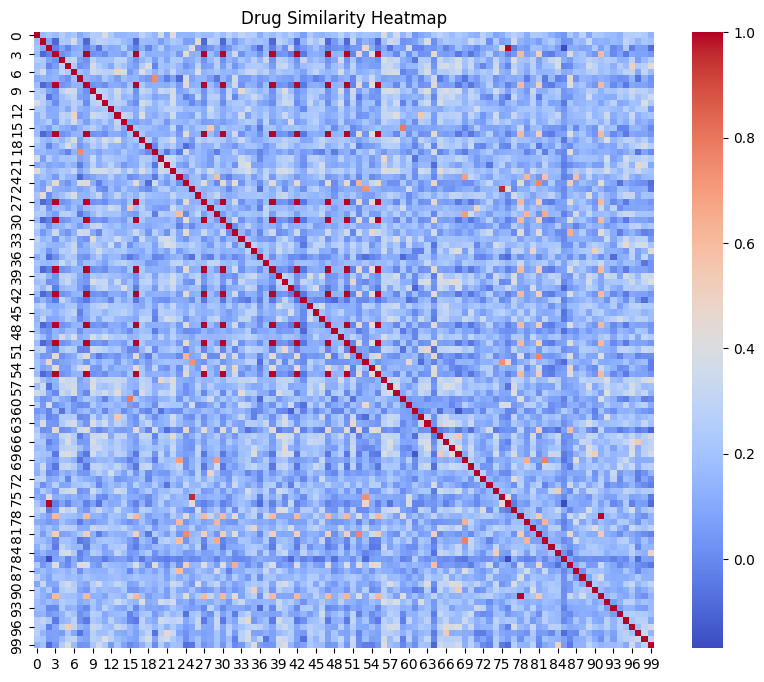

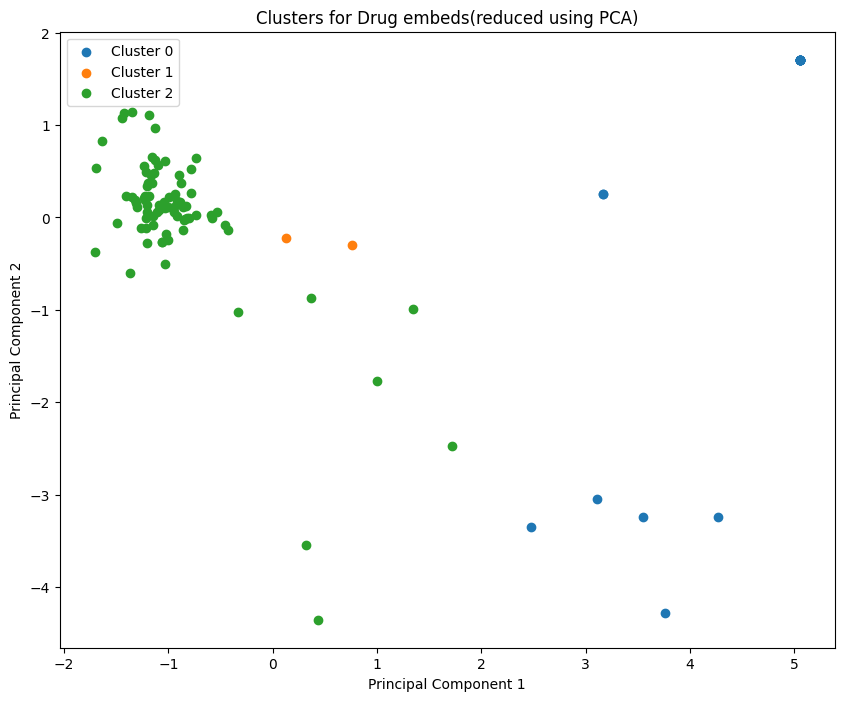

             type     created     updated drugbank-id  \
0         biotech  2015-09-17  2022-03-11     DB09108   
1  small molecule  2008-03-19  2020-06-12     DB06253   
2         biotech  2018-07-05  2020-06-12     DB14424   
3  small molecule  2005-06-13  2020-06-12     DB01649   
4  small molecule  2015-11-27  2021-09-28     DB09350   

                                                name  \
0                                    Simoctocog alfa   
1                         Thioctic acid tromethamine   
2  Influenza A virus A/Hong Kong/4801/2014 X-263B...   
3                                     7-methyl-GpppA   
4                                 Piperonyl butoxide   

                                         description    cas-number  \
0  Simoctocog alfa is a recombinant B-domain dele...  1219013-68-9   
1  A salt of alpha-lipoic acid and tromethamine; ...   137314-40-0   
2  A seasonally-specific component of the influen...           NaN   
3                                       

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [10]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/MyDrive/Bio_Info project/drugbank_clean.csv'
df=pd.read_csv(file_path)

from transformers import pipeline, AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
if df.empty:
  raise ValueError("The DataFrame is empty. Please check your data.")
print(f"Dataset contains{df.shape[0]} rows and {df.shape[1]} columns.")
print(df.head())

def preprocess_text(text):
  if isinstance(text, str):
    return text.strip().lower()
  return ""
if 'description' in df.columns:
  df['description_cleaned']=df['description'].apply(preprocess_text)
else:
  raise KeyError("The Dataset does not contain a 'description' column.")
if 'mechanism_of_action' in df.columns:
  df['mechanism_cleaned'] = df['mechanism_of_action'].apply(preprocess_text)
else:
  df['mechanism_cleaned'] = ""
  print("Warning: 'mechanism_of_action' column is missing from the dataset.")
  df['mechanism_cleaned'] = None
df=df[df['description_cleaned']!=""].reset_index(drop=True)
if df.empty:
  raise ValueError("All rows have empty 'description_cleaned'. Ensure the dataset contains valid descriptions")
print("Missing values per column")
print(df.isnull().sum())

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model= AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def generate_embeddings(text):
  if text is None or text == "":
    return np.zeros((model.config.hidden_size))
  inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
  outputs = model(**inputs)
  return outputs.last_hidden_state.mean(dim=1).detach().numpy()

df['description_embedding']=df['description_cleaned'].apply(generate_embeddings)
if len(df)<100:
  raise ValueError("The dataset has fewer than 100 rows. Increase the dataset size or adjust the sample size.")
df_sample=df.sample(n=min(len(df),100), random_state=42).reset_index(drop=True)
embeddings=np.vstack(df_sample['description_embedding'].values)

similarity_matrix=cosine_similarity(embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Drug Similarity Heatmap')
plt.show()

num_clusters=3
kmeans=KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels=kmeans.fit_predict(embeddings)
df_sample['cluster'] = cluster_labels
pca=PCA(n_components=2)
reduced_embeddings=pca.fit_transform(embeddings)
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
  cluster_points = reduced_embeddings[cluster_labels == cluster]
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
plt.title("Clusters for Drug embeds(reduced using PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

from sklearn.preprocessing import LabelEncoder, StandardScaler
if 'mechanism_cleaned' in df_sample.columns:
  le = LabelEncoder()
  df_sample['mechanism_cleaned'] = le.fit_transform(df_sample['mechanism_cleaned'].fillna("unknown"))

numeric_columns = df_sample.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
df_sample[numeric_columns] = scaler.fit_transform(df_sample[numeric_columns])
print(df_sample.head())

silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")
if 'mechanism_cleaned' in df_sample.columns and not df_sample['mechanism_cleaned'].isnull().all():
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  mechanism_labels = le.fit_transform(df_sample['mechanism_cleaned'])
  ari = adjusted_rand_score(mechanism_labels, cluster_labels)
  print(f"adjusted Rand Index: {ari:.2f}")

for cluster in range(num_clusters):
  print(f"\nCluster {cluster}:")
  cluster_drugs = df_sample[df_sample['cluster']==cluster]
  print(cluster_drugs[['description_cleaned','mechanism_cleaned']].head())

In [9]:
X_train, X_test, y_train, y_test= train_test_split(embeddings, df_sample['mechanism_cleaned'], test_size=0.2, random_state=42)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

candidate_labels = ['enzyme inhibitor', 'receptor agonist', 'antibiotic']
if not df_sample['description_cleaned'].empty:
    example_text = df_sample['description_cleaned'][0]
    print("Example Text:\n", example_text)
    result = classifier(example_text, candidate_labels=candidate_labels)
    print("\nClassification Result:", result)
else:
    print("No valid descriptions available for classification.")



processed_file_path = 'processed_drugbank_data.csv'
df.to_csv(processed_file_path, index=False)
print(f"Processed dataset saved to {processed_file_path}")

processed_file_path_with_clusters = 'processed_drugbank_with_clusters.csv'
df_sample.to_csv(processed_file_path_with_clusters, index=False)
print(f"Processed dataset with clusters saved to {processed_file_path_with_clusters}")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Example Text:
 simoctocog alfa is a recombinant b-domain deleted (bdd) rfviii produced in genetically modified human embryonic kidney (hek) 293f cells. the harvested product is concentrated and purified by a series of chromatography steps. it is an antihemorrhagic agent used as a replacement therapy in individuals with haemophilia a who lack the factor viii in the intrinsic pathway of blood coagulation system. as patients with haemophilia a are predisposed to episodes of recurrent bleeding [l1115], simoctocog alfa can be administered for the treatment or prevention of bleeding such as prior to surgical procedures.

simoctocog alfa is a glycoprotein consisting of 1440 amino acids with an approximate molecular mass of 170 kda, comprising the fviii domains a1-a2 + a3-c1-c2 whereas the b-domain, present in the full-length plasma-derived fviii, has been deleted and replaced by a 16 amino acid linker. simoctocog alfa is a fourth-generation bdd fviii product made in the human embryonic kidney

Numeric columns for imputation: ['average-mass', 'monoisotopic-mass', 'mechanism_cleaned', 'cluster']
Imputation completed. Dataset after imputation:
   average-mass  monoisotopic-mass  mechanism_cleaned   cluster
0  1.569115e-16       1.310063e-16                0.0  0.476664
1 -2.984826e-01      -2.984991e-01                0.0  0.476664
2  1.569115e-16       1.310063e-16                0.0  0.476664
3  1.304519e+00       1.305496e+00                0.0 -2.171471
4 -2.601893e-01      -2.598207e-01                0.0  0.476664
Number of Clusters: 2, Silhouette Score: 0.65
Number of Clusters: 3, Silhouette Score: 0.66
Number of Clusters: 4, Silhouette Score: 0.57
Number of Clusters: 5, Silhouette Score: 0.60
Number of Clusters: 6, Silhouette Score: 0.65
Number of Clusters: 7, Silhouette Score: 0.64
Number of Clusters: 8, Silhouette Score: 0.64
Number of Clusters: 9, Silhouette Score: 0.65
Number of Clusters: 10, Silhouette Score: 0.66


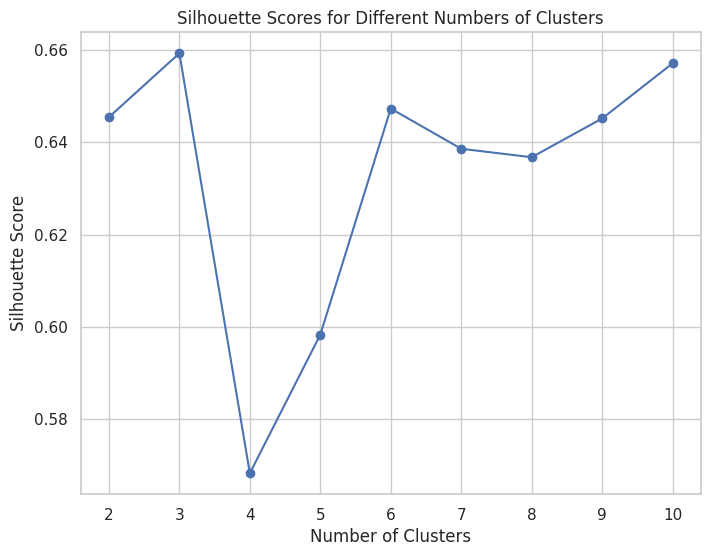

The best number of clusters is 3 with a silhouette score of 0.66


<ipython-input-10-be6f54853f1c>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='average-mass', data=df_sample, palette="Set2")


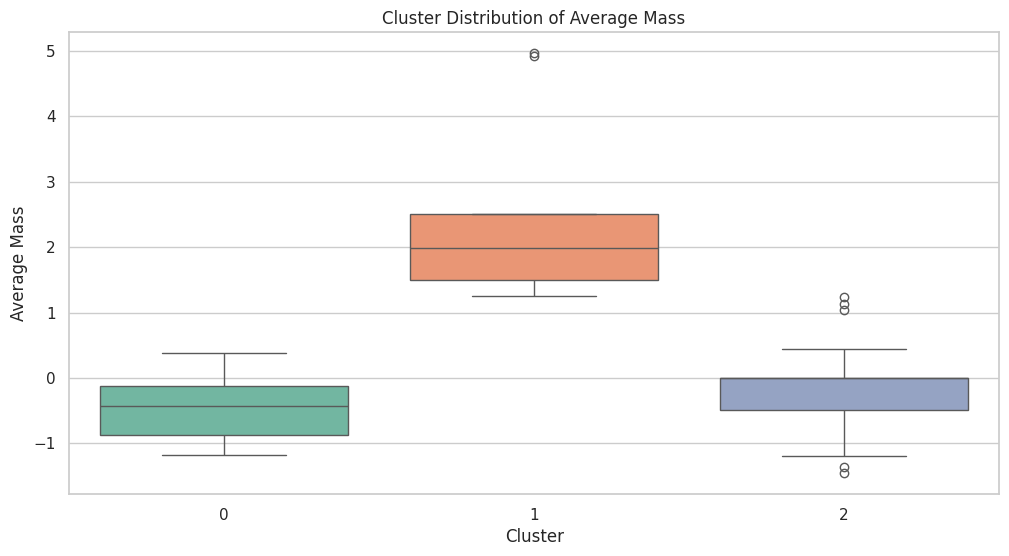

<ipython-input-10-be6f54853f1c>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='monoisotopic-mass', data=df_sample, palette="Set3")


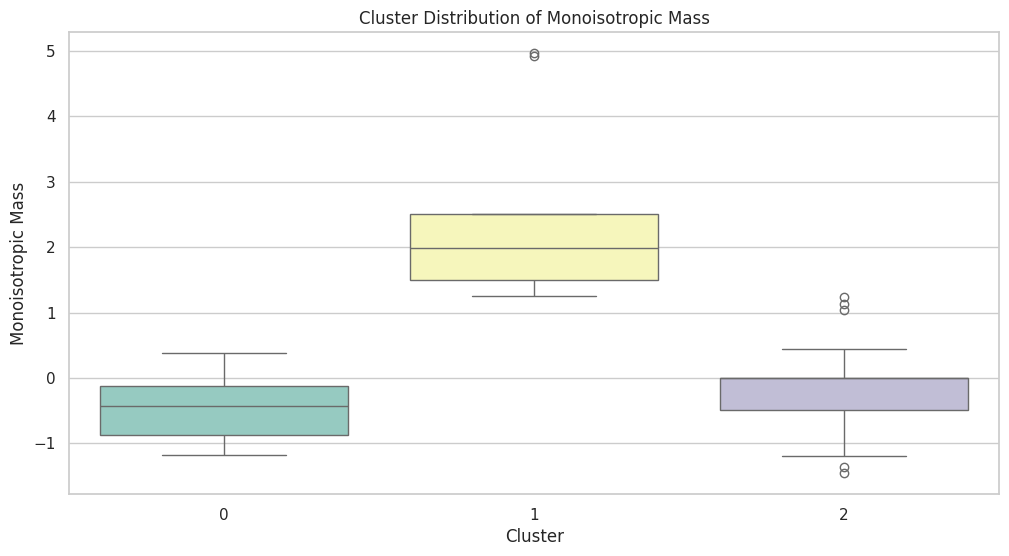

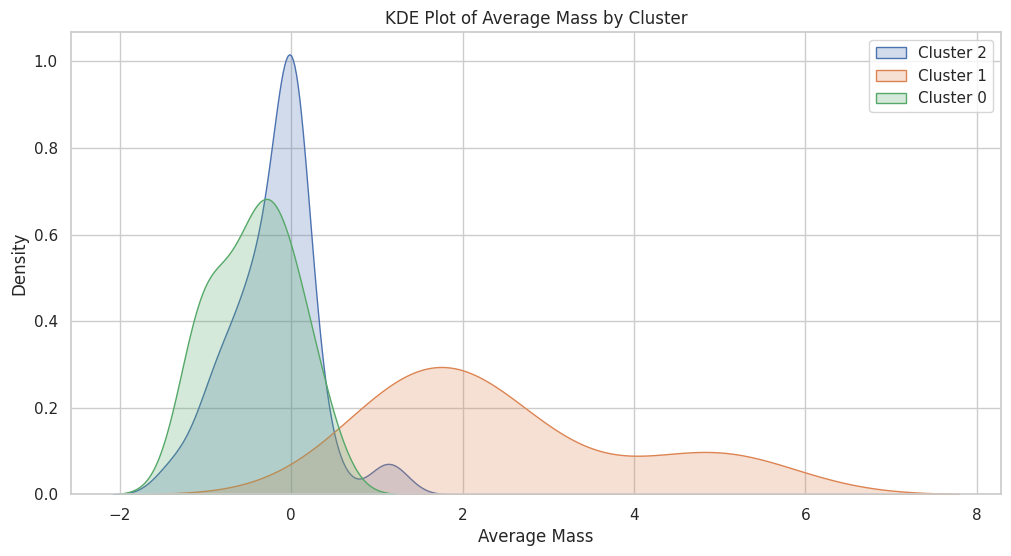

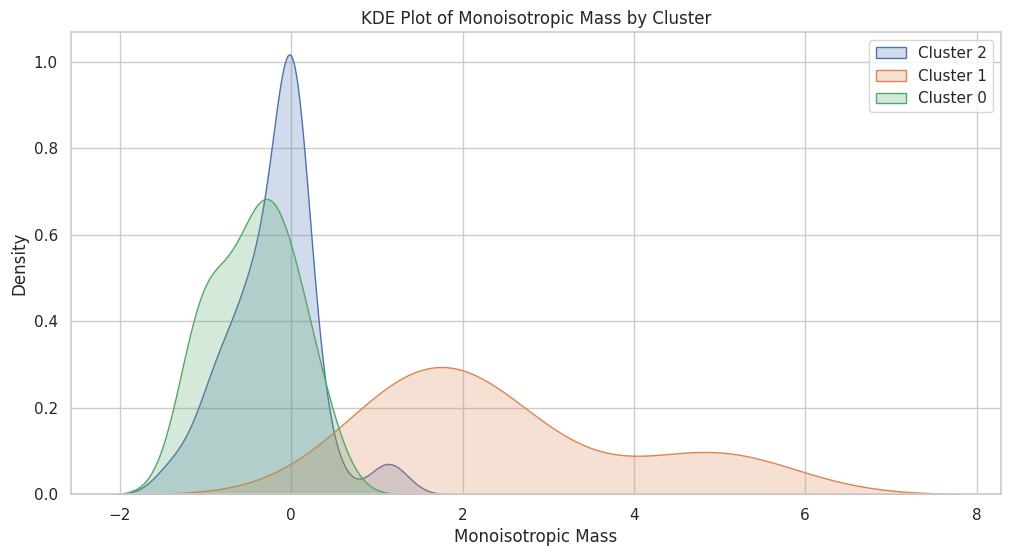

In [ ]:
from sklearn.impute import SimpleImputer
numeric_columns = df_sample.select_dtypes(include=[np.number]).columns.tolist()

numeric_columns = [col for col in numeric_columns if df_sample[col].notna().sum() > 0]

if 'description_embedding' in numeric_columns:
    numeric_columns.remove('description_embedding')

print(f"Numeric columns for imputation: {numeric_columns}")
imputer = SimpleImputer(strategy='mean')

df_sample[numeric_columns] = imputer.fit_transform(df_sample[numeric_columns])
print(f"Imputation completed. Dataset after imputation:\n{df_sample[numeric_columns].head()}")

if 'description_embedding' in numeric_columns:
    numeric_columns.remove('description_embedding')
scaler = StandardScaler()
df_sample[numeric_columns] = scaler.fit_transform(df_sample[numeric_columns])

silhouette_scores = []
range_of_clusters = range(2, 11)
for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_sample[numeric_columns])

    silhouette_avg = silhouette_score(df_sample[numeric_columns], cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of Clusters: {k}, Silhouette Score: {silhouette_avg:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(range_of_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = range_of_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"The best number of clusters is {best_k} with a silhouette score of {max(silhouette_scores):.2f}")

#the following is for average mass:check ANOVA
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_sample[numeric_columns])
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='average-mass', data=df_sample, palette="Set2")
plt.title('Cluster Distribution of Average Mass')
plt.xlabel('Cluster')
plt.ylabel('Average Mass')
plt.show()

#avg-mass KDE plot
plt.figure(figsize=(12, 6))
for cluster in df_sample['cluster'].unique():
  subset = df_sample[df_sample['cluster'] == cluster]
  sns.kdeplot(subset['average-mass'], label=f'Cluster {cluster}', fill=True)
plt.title('KDE Plot of Average Mass by Cluster')
plt.xlabel('Average Mass')
plt.ylabel('Density')
plt.legend()
plt.show()